# TensorFlores - Example 4

## 1. Importing libraries

In [1]:
import sys, os
path = os.getcwd().split('\\examples')[0]
sys.path.append(path)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflores.utils.cpp_generation import CppGeneration
from tensorflores.utils.clustering import ClusteringMethods
from tensorflores.utils.json_handle import JsonHandle
from tensorflores.utils.quantization import Quantization

## 2. Load Dataset

In [3]:
df = pd.read_csv(path + '\\data\\emission_total.csv')
df.head(5)

,CO2 (g/s) [estimated maf],CO2 (g/s) [maf],estimated_maf,intake_pressure,intake_temperature,latitude,longitude,maf,rpm,speed
0,0.809921,0.639659,3.798529,26.0,54.0,-5.793477,-35.198093,3.0,1568.0,43.0
1,1.796942,2.132196,8.427658,57.0,53.0,-5.793538,-35.198116,10.0,1582.0,43.0
2,2.199995,2.132196,10.317979,69.0,53.0,-5.793600,-35.198139,10.0,1600.0,43.0
3,1.226761,0.639659,5.753511,38.0,54.0,-5.793665,-35.198170,3.0,1625.0,44.0
4,0.756202,0.426439,3.546585,24.0,54.0,-5.793739,-35.198196,2.0,1586.0,45.0


In [4]:
scaler = MinMaxScaler()
values_df = scaler.fit_transform(df[['intake_pressure', 'intake_temperature', 'speed', 'CO2 (g/s) [maf]']])

In [5]:
X = values_df[:,0:3]
y = values_df[:,3:]

## 3. Splitting the data

In [6]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## 4. Define the model

In [8]:
model = tf.keras.Sequential()
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))

## 5. Compile the model

In [9]:
# configure the optimizer, loss, and metrics to monitor.
opt = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name='Adam')

# Compile the model
model.compile(optimizer=opt, loss='mse', metrics=["mse"])

## 6. Training model

In [10]:
history = model.fit(X_train, y_train,
                    batch_size=36,
                    epochs=100,
                    validation_split = 0.1,
                    verbose=1)

Epoch 1/100


205/205 [==============================] - 2s 4ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 2/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 3/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 4/100
205/205 [==============================] - 0s 2ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 5/100
205/205 [==============================] - 0s 2ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 6/100
205/205 [==============================] - 0s 2ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/100
205/205 [==============================] - 0s 2ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 8/100
205/205 [==============================] - 0s 2ms/step 

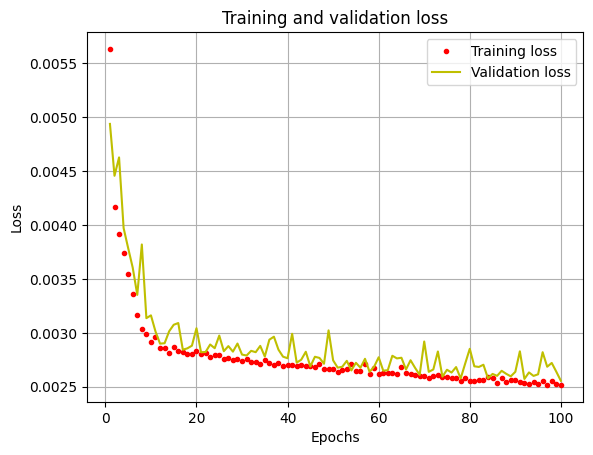

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [12]:
model.save('model.keras')

In [13]:
print('Input test: ', X_test[0])

Input test:  [0.07407407 0.07142857 0.94936709]


In [14]:
print('Predict test: ', model.predict(X_test)[0])

64/64 [==============================] - 0s 1ms/step
Predict test:  [0.1056415]


In [15]:
error = model.predict(X_test) - y_test

64/64 [==============================] - 0s 1ms/step


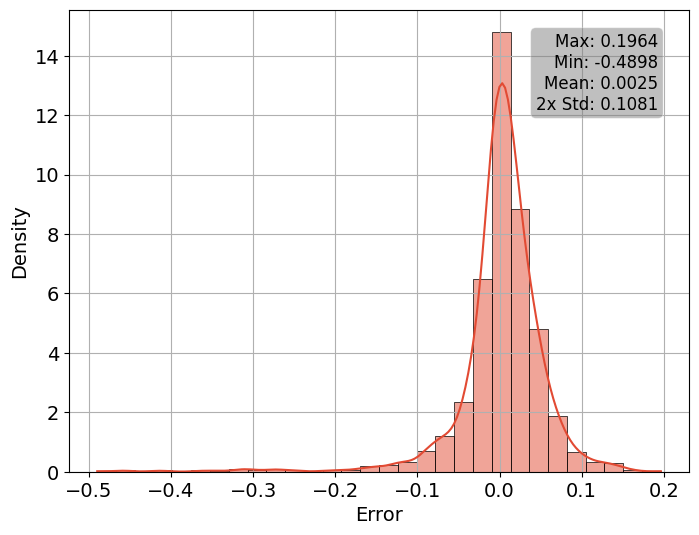

In [16]:
# Estatísticas
error_mean = np.mean(error)
error_std = np.std(error)
error_max = np.max(error)
error_min = np.min(error)

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize=(8, 6))

# Estilo do gráfico
plt.style.use('ggplot')

# Plotando histograma com KDE (Densidade) sem legenda
sns.histplot(error, bins=30, color='coral', edgecolor='black', stat="density", kde=True, legend=False, ax=ax)

# Configuração dos eixos
ax.set_xlabel('Error', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
#ax.set_title('Error Distribution', fontsize=15)
ax.tick_params(labelsize=14)
ax.grid(True)

# Definindo limites do eixo X
#ax.set_xlim(error_min, error_max)

# Exibir os valores estatísticos no gráfico
textstr = '\n'.join((
    f'Max: {error_max:.4f}',
    f'Min: {error_min:.4f}',
    f'Mean: {error_mean:.4f}',
    f'2x Std: {2 * error_std:.4f}'
))
props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.savefig('./figures/example_04_tensorflow.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
# Exibir gráfico
plt.show()

## 7. TensorFlores converter

### 7.2 Convert the Tensorflow model, using post quantization int8 and total (weights eand biases)

#### 7.2.1 Save as Json

In [17]:
model_as_json = JsonHandle().convert_tensorflow_model_to_json(tensorflow_model = model)
model_as_json

{'num_layers': 3,
 'model_quantized': False,
 'layers': [{'activation': 'relu',
   'weights': [[0.2285795658826828,
     0.2654980421066284,
     0.14224828779697418,
     0.27832165360450745,
     0.34304168820381165,
     -0.15471047163009644,
     0.08229552954435349,
     0.03697875887155533,
     0.574588418006897,
     0.27221933007240295,
     0.3698675036430359,
     0.18740126490592957,
     -0.26425471901893616,
     0.4140512943267822,
     0.23558038473129272,
     0.5731029510498047],
    [0.4169730246067047,
     -0.022036394104361534,
     -0.02404852770268917,
     0.33149805665016174,
     0.10844071209430695,
     -0.25959524512290955,
     0.02713972143828869,
     0.005249979440122843,
     -0.3045799136161804,
     -0.53950434923172,
     0.0019521538633853197,
     0.11642161011695862,
     0.1585088074207306,
     -0.40965735912323,
     0.1827041506767273,
     -0.008208598010241985],
    [0.3087541162967682,
     0.3623913824558258,
     0.5005401968955994,
   

In [18]:
cpp_model = CppGeneration().generate_cpp_from_json(json_data = model_as_json, file_name = 'tensorflow_model')

Model C++ saved!


In [19]:

Clustering_method = ClusteringMethods()

bias_clustering_method = Clustering_method.autocloud_biases(threshold_biases = 1.4148)
weight_clustering_method = Clustering_method.autocloud_weight(threshold_weights = 1.4148)
Quantization().post_training_quantization(json_data = model_as_json, quantization_type = 'evolving', distance_metric = "euclidean", 
        bias_clustering_method = bias_clustering_method,
        weight_clustering_method = weight_clustering_method)

{'num_layers': 3,
 'model_quantized': 'evolving',
 'layers': [{'activation': 'relu',
   'weights': [[0, 0, 0, 0, 3, 2, 4, 4, 3, 0, 3, 0, 2, 3, 0, 3],
    [3, 4, 4, 3, 0, 2, 4, 4, 2, 1, 4, 0, 0, 2, 0, 4],
    [3, 3, 3, 3, 1, 2, 1, 3, 3, 4, 3, 0, 3, 4, 0, 0]],
   'biases': [0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]},
  {'activation': 'relu',
   'weights': [[2, 3, 2, 4, 4, 4, 4, 2],
    [0, 0, 4, 1, 4, 2, 0, 0],
    [2, 2, 4, 2, 3, 2, 2, 2],
    [3, 0, 0, 4, 3, 2, 2, 2],
    [2, 0, 3, 0, 2, 4, 0, 4],
    [4, 2, 3, 2, 4, 4, 0, 0],
    [2, 1, 2, 3, 0, 3, 3, 2],
    [0, 3, 2, 4, 2, 4, 3, 0],
    [4, 3, 2, 0, 2, 2, 4, 4],
    [1, 4, 3, 3, 2, 0, 2, 4],
    [2, 0, 2, 0, 3, 3, 2, 2],
    [2, 2, 1, 2, 4, 1, 4, 3],
    [4, 3, 3, 2, 0, 2, 2, 4],
    [3, 0, 2, 1, 3, 2, 4, 2],
    [4, 4, 2, 4, 2, 3, 2, 2],
    [0, 0, 4, 3, 1, 2, 3, 2]],
   'biases': [0, 0, 0, 1, 0, 0, 0, 0]},
  {'activation': 'linear',
   'weights': [[3], [3], [4], [1], [1], [2], [1], [3]],
   'biases': [0]}],
 'centers_bias': 

In [20]:
cpp_model = CppGeneration().generate_cpp_from_json(json_data = model_as_json, file_name = 'tensorflow_evolving')

Model C++ saved!


In [21]:
model_as_json_int8 = Quantization().post_training_quantization(json_data = model_as_json,
                                        quantization_type = 'int8')

In [22]:
model_as_json_int8

{'num_layers': 3,
 'model_quantized': 'int8',
 'layers': [{'activation': 'relu',
   'weights': [[214,
     216,
     209,
     217,
     221,
     191,
     205,
     203,
     235,
     217,
     222,
     212,
     185,
     225,
     215,
     234],
    [225,
     199,
     199,
     220,
     207,
     185,
     202,
     201,
     183,
     169,
     201,
     207,
     210,
     176,
     211,
     200],
    [219,
     222,
     230,
     219,
     160,
     173,
     139,
     232,
     219,
     200,
     230,
     212,
     233,
     205,
     218,
     210]],
   'biases': [198,
    193,
    189,
    203,
    208,
    201,
    209,
    177,
    207,
    202,
    203,
    199,
    193,
    195,
    196,
    190]},
  {'activation': 'relu',
   'weights': [[174, 222, 190, 206, 195, 201, 200, 180],
    [217, 216, 199, 0, 203, 191, 217, 207],
    [175, 177, 206, 187, 241, 182, 186, 192],
    [223, 209, 213, 200, 225, 175, 174, 194],
    [178, 216, 225, 206, 180, 203, 211, 205],
    

In [23]:
cpp_model_int8 = CppGeneration().generate_cpp_from_json(json_data = model_as_json_int8, file_name = 'tensorflow_int8')

Model C++ saved!
